Q 1.1

In [10]:
import re
from collections import Counter

# === Load datasets ===
with open('leo.txt', 'r', encoding='utf-8') as f:
    leo_text = f.read()

# Handle non-UTF8 characters safely in algebra file
with open('algebra.txt', 'r', encoding='utf-8', errors='ignore') as f:
    algebra_text = f.read()


# === Preprocessing functions ===
def preprocess_natural(text):
    """Preprocess natural language text (Category I)."""
    text = re.sub('[^a-zA-Z0-9 \.]', ' ', text)  # remove special chars except '.'
    text = text.lower()
    words = text.split()
    return words


def preprocess_structured(text):
    """Preprocess structured/math/LaTeX text (Category II)."""
    text = text.lower()  # keep case uniform
    lines = text.split('\n')
    words = []
    for line in lines:
        line = line.strip()
        if line:
            tokens = line.split()  # keep all characters as-is
            words.extend(tokens)
    return words


# === Apply preprocessing ===
leo_words = preprocess_natural(leo_text)
algebra_words = preprocess_structured(algebra_text)


# === Function to get vocabulary stats ===
def vocab_stats(words, name):
    word_counts = Counter(words)
    vocab = sorted(word_counts.keys())
    vocab_size = len(vocab)
    most_common = word_counts.most_common(10)
    least_common = word_counts.most_common()[:-11:-1]

    print(f"\n\n=== {name} Vocabulary Statistics ===")
    print("Total Words:", len(words))
    print("Vocabulary Size:", vocab_size)
    print("\n10 Most Frequent Words:")
    for word, freq in most_common:
        print(f"{word}: {freq}")
    print("\n10 Least Frequent Words:")
    for word, freq in least_common:
        print(f"{word}: {freq}")

    return word_counts, vocab


# === Display stats for both datasets ===
leo_counts, leo_vocab = vocab_stats(leo_words, "Leo Tolstoy (Natural Text)")
algebra_counts, algebra_vocab = vocab_stats(algebra_words, "Algebra (Structured Text)")


# === Save cleaned text for reuse ===
with open('leo_cleaned.txt', 'w', encoding='utf-8') as f:
    f.write(' '.join(leo_words))

with open('algebra_cleaned.txt', 'w', encoding='utf-8') as f:
    f.write(' '.join(algebra_words))



=== Leo Tolstoy (Natural Text) Vocabulary Statistics ===
Total Words: 572182
Vocabulary Size: 22982

10 Most Frequent Words:
the: 34544
and: 22221
to: 16637
of: 14870
a: 10541
he: 9885
in: 8920
that: 8115
his: 7973
was: 7323

10 Least Frequent Words:
unreal: 1
immovability: 1
erected.: 1
strengthens: 1
uninvited: 1
conceptions.: 1
nun.: 1
joshua: 1
firmament: 1
provokes: 1


=== Algebra (Structured Text) Vocabulary Statistics ===
Total Words: 273197
Vocabulary Size: 20889

10 Most Frequent Words:
is: 9290
the: 8532
a: 6771
of: 6626
=: 5256
\to: 5120
that: 4381
and: 4313
we: 3699
let: 3102

10 Least Frequent Words:
\end{document}: 1
\bibliographystyle{amsalpha}: 1
\bibliography{my}: 1
\input{chapters}: 1
part): 1
faithfulness: 1
(except: 1
$gg'$: 1
quasi-finiteness: 1
\ref{theorem-openness-flatness}),: 1


Dataset 2 | Algebra

Q 1.2

cuda
Epoch 1: Train loss=5.8977, Val loss=5.0162, Val acc=0.2321
Epoch 2: Train loss=4.9407, Val loss=4.5784, Val acc=0.2695
Epoch 3: Train loss=4.5747, Val loss=4.3576, Val acc=0.2891
Epoch 4: Train loss=4.3368, Val loss=4.2235, Val acc=0.2995
Epoch 5: Train loss=4.1639, Val loss=4.1244, Val acc=0.3118
Epoch 6: Train loss=4.0390, Val loss=4.0529, Val acc=0.3160
Epoch 7: Train loss=3.9272, Val loss=3.9961, Val acc=0.3231
Epoch 8: Train loss=3.8398, Val loss=3.9617, Val acc=0.3253
Epoch 9: Train loss=3.7643, Val loss=3.9228, Val acc=0.3290
Epoch 10: Train loss=3.6938, Val loss=3.8923, Val acc=0.3358
Epoch 11: Train loss=3.6365, Val loss=3.8709, Val acc=0.3388
Epoch 12: Train loss=3.5842, Val loss=3.8574, Val acc=0.3378
Epoch 13: Train loss=3.5369, Val loss=3.8388, Val acc=0.3432
Epoch 14: Train loss=3.4946, Val loss=3.8259, Val acc=0.3466
Epoch 15: Train loss=3.4524, Val loss=3.8190, Val acc=0.3455
Epoch 16: Train loss=3.4163, Val loss=3.8048, Val acc=0.3482
Epoch 17: Train loss=3.3859,

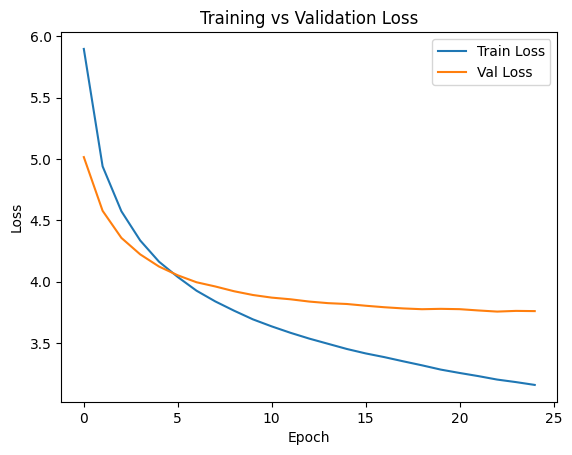

Final Validation Loss: 3.7611
Final Validation Accuracy: 0.3601
if you are not familiar with most of the form $$ 0 \to m_1 \to m_2 \to m_3


In [11]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

# --- Load Cleaned Text File ---
with open('algebra_cleaned.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# --- Build Vocabulary ---
words = text.split()
vocab = sorted(set(words))
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}
vocab_size = len(vocab)

# --- Prepare Input Sequences and Targets ---
SEQ_LEN = 5
sequences = []
targets = []
for i in range(len(words) - SEQ_LEN):
    sequences.append([word2idx[w] for w in words[i : i + SEQ_LEN]])
    targets.append(word2idx[words[i + SEQ_LEN]])

X = np.array(sequences)
y = np.array(targets)

# --- Split Train and Validation Sets ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42
)

# --- Dataset & DataLoader ---
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.LongTensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 128
train_ds = TextDataset(X_train, y_train)
val_ds = TextDataset(X_val, y_val)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE)

# --- Model Definition ---
EMBED_DIM = 64
HIDDEN_DIM = 1024
N_LAYERS = 2
ACTIVATION = 'relu'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)
criterion = nn.CrossEntropyLoss()

class MLPTextGen(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, activation, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        layers = [nn.Linear(embed_dim * SEQ_LEN, hidden_dim)]
        act = nn.ReLU() if activation == 'relu' else nn.Tanh()
        layers.append(act)
        layers.append(nn.Dropout(dropout))  # Dropout after first hidden layer
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(act)
            layers.append(nn.Dropout(dropout))  # Dropout after subsequent hidden layers
        layers.append(nn.Linear(hidden_dim, vocab_size))
        self.layers = nn.Sequential(*layers)
    def forward(self, x):
        embedded = self.embedding(x)
        flattened = embedded.view(embedded.size(0), -1)
        return self.layers(flattened)

dropout_rate = 0.5
model = MLPTextGen(vocab_size, EMBED_DIM, HIDDEN_DIM, N_LAYERS, ACTIVATION, dropout=dropout_rate).to(DEVICE)

weight_decay = 5e-5
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=weight_decay)


# --- Training Loop ---
EPOCHS = 25
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validate
    model.eval()
    total_loss = 0
    total_correct = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
            pred = out.argmax(dim=1)
            total_correct += (pred == yb).sum().item()
    val_loss = total_loss / len(val_loader.dataset)
    val_acc = total_correct / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}: Train loss={train_loss:.4f}, Val loss={val_loss:.4f}, Val acc={val_acc:.4f}")

# --- Plot Training vs Validation Loss ---
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

print(f'Final Validation Loss: {val_losses[-1]:.4f}')
print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

def generate_text(seed_seq, num_words=10):
    model.eval()
    seq = seed_seq.split()
    for _ in range(num_words):
        inp = [word2idx.get(w, 0) for w in seq[-SEQ_LEN:]]
        inp = torch.LongTensor([inp]).to(DEVICE)
        out = model(inp)
        pred_idx = out.argmax(dim=1).item()
        pred_word = idx2word[pred_idx]
        seq.append(pred_word)
    return ' '.join(seq)

seed = "if you are not familiar with most of"
print(generate_text(seed))

Q 1.3

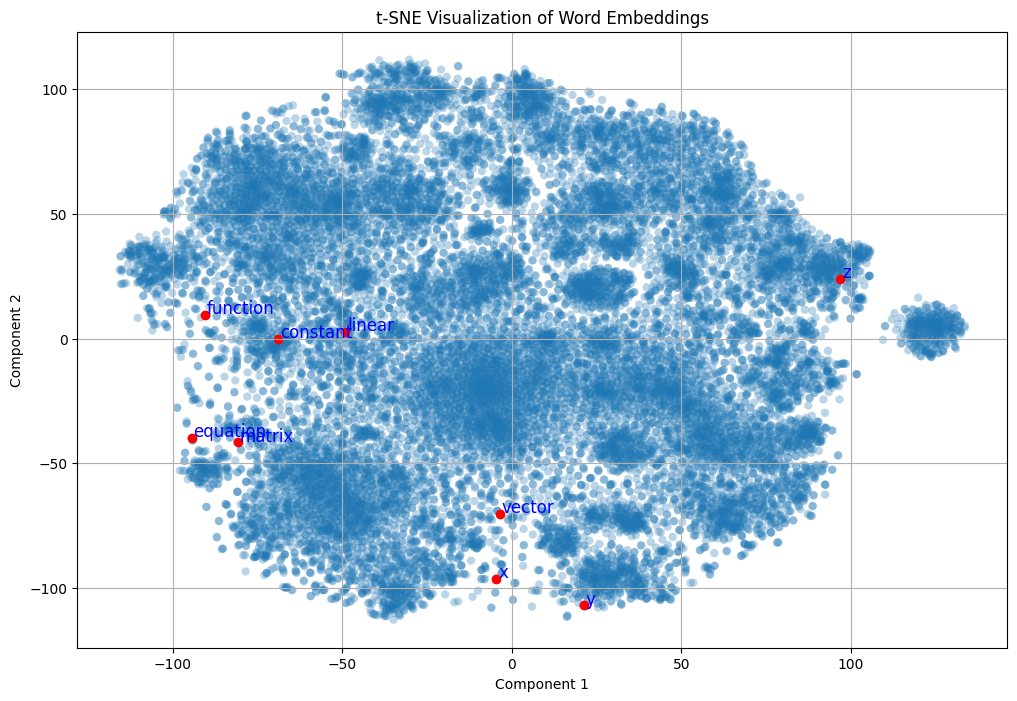

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

selected_words = ['matrix', 'vector', 'equation', 'function', 'solve', 'x', 'y', 'z', 'linear', 'constant']
selected_idx = [word2idx[w] for w in selected_words if w in word2idx]

tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=5000)
embeddings_2d = tsne.fit_transform(model.embedding.weight.data.cpu().numpy())

plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.3, edgecolors='none')

for idx in selected_idx:
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], color='red')
    plt.text(embeddings_2d[idx, 0] + 0.5, embeddings_2d[idx, 1] + 0.5, idx2word[idx], fontsize=12, color='blue')

plt.title("t-SNE Visualization of Word Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()